In [1]:
import cv2
import os
import glob
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load camera calibration
with open('camera_cal.p', mode='rb') as f:
    camera_cal=pickle.load(f)
mtx=camera_cal['mtx']
dist=camera_cal['dist']

In [2]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomal cofficient for current fit
        self.fit = None
        #polynomial coefficients for the most recent fit
        self.fit_stack = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = 0 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None


left_line=Line()
right_line=Line()

In [3]:
# Use color transforms, gradients, etc., to create a thresholded binary image.
# Colour transform
def color_thresh(img, thresh=(0,255), hue_thresh=(0,30)):
    hls=cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h=hls[:,:,0]
    s=hls[:,:,2]

    # Color threshold to isolate yellow and white 
    s_binary=np.zeros_like(s)
    s_binary[[((s>=thresh[0]) & (s<=thresh[1]))]]=1
    
    h_binary=np.zeros_like(s)
    h_binary[[((h>=hue_thresh[0]) & (h<=hue_thresh[1]))]]=1    
    
    color_binary=np.zeros_like(s)
    color_binary= s_binary & h_binary
    #plt.imshow(np.dstack((255*s_binary,np.zeros_like(s), s)))
    #plt.show()
    return (color_binary)


In [4]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0,255)):
    
    # Apply the following steps to img
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    #default is to use sobel x
    if orient=='x':
        gradient=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    if orient=='y':
        gradient=cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)        

    # 3) Take the absolute value of the derivative or gradient
    abs_grad=np.absolute(gradient)

    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scale_factor=np.max(abs_grad)/255.0
    abs_grad=(abs_grad/scale_factor).astype(np.uint8)

    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    mask=[(abs_grad>thresh[0]) & (abs_grad<thresh[1])]

    # 6) Return this mask as your binary_output image
    binary_output=np.zeros_like(abs_grad).astype(np.uint8)
    binary_output[mask]=1    
    return binary_output

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
   
    # Apply the following steps to img
    # 2) Take the gradient in x and y separately
    sobelx=cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely=cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude
    sobel_mag=np.sqrt(sobelx**2+sobely**2)
    # 5) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    with np.errstate(divide='ignore', invalid='ignore'):
        sobel_mag=np.uint8(255*sobel_mag/np.max(sobel_mag))
    # 6) Create a binary mask where mag thresholds are met
    mask =[(sobel_mag > mag_thresh[0]) & (sobel_mag < mag_thresh[1])]
    # 7) Return this mask as your binary_output image
    binary_output=np.zeros_like(sobel_mag).astype(np.uint8)
    binary_output[mask] = 1
    return binary_output

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):    
    # 2) Take the gradient in x and y separately
    sobelx=cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely=cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the direction of the gradient 
    with np.errstate(divide='ignore', invalid='ignore'):
        sobel_phase=np.arctan(sobely/(sobelx))
        # 4) Take the absolute value
        sobel_abs_phase=np.absolute(sobel_phase)
        # 5) Create a binary mask where direction thresholds are met
        mask =[(sobel_abs_phase > thresh[0]) & (sobel_abs_phase < thresh[1])]
        # 6) Return this mask as your binary_output image
        dir_binary=np.zeros_like(sobel_abs_phase).astype(np.uint8)
        dir_binary[mask] = 1
    return dir_binary

def detect_sobel_edges(gray):
    ksize=13
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(10, 255))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(50, 255))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0.15*np.pi/2, 0.85*np.pi/2))
    
    edges = np.zeros_like(dir_binary)
    edges[((gradx == 1) & (dir_binary == 1) & (mag_binary == 1))] = 1

    return edges


In [5]:
# Region masking
def region_masking(img):
    ysize = img.shape[0]
    xsize = img.shape[1]

    left_bottom = [0.0*xsize, ysize-1]
    left_top = [0.45*xsize, 0.6*ysize]
    right_top = [0.55*xsize, 0.6*ysize]
    right_bottom = [1*xsize, ysize-1]

    # Fit lines (y=Ax+B) to identify the  3 sided region of interest
    # np.polyfit() returns the coefficients [A, B] of the fit
    fit_left = np.polyfit((left_bottom[0], left_top[0]), (left_bottom[1], left_top[1]), 1)
    fit_top = np.polyfit((left_top[0], right_top[0]), (left_top[1], right_top[1]), 1)
    fit_right = np.polyfit((right_top[0], right_bottom[0]), (right_top[1], right_bottom[1]), 1)
    fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

    # Find the region inside the lines
    XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
    region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                        (YY > (XX*fit_top[0] + fit_top[1])) & \
                        (YY > (XX*fit_right[0] + fit_right[1])) & \
                        (YY < (XX*fit_bottom[0] + fit_bottom[1]))

    binary_lane=np.zeros_like(img)
    binary_lane[region_thresholds & (img==1)]=1
        
    return binary_lane

In [6]:
def bird_eye(img, src_pts, dst_pts):
    
    M = cv2.getPerspectiveTransform(src_pts,dst_pts)
    
    warped=cv2.warpPerspective(img,M,img.shape[::-1],flags=cv2.INTER_LINEAR)
    return warped, M

# Find lane boundary
# Function to find lane boundary and return an binary image
def find_lane(img, line, x_init_pos):
    shape_ymax, shape_xmax=img.shape
    windowed=np.zeros_like(img)
    
    wdw_dy=4*36
    wdw_dx=100
    x_mean=x_init_pos
    
    for y in range(shape_ymax, 0, -wdw_dy):
        
        wdw=img[y-wdw_dy:y,x_mean-wdw_dx:x_mean+wdw_dx].copy()
        windowed[y-wdw_dy:y,x_mean-wdw_dx:x_mean+wdw_dx]=wdw.copy()
        # Calculate new mean of x

        histogram = np.sum(wdw, axis=0)
        if (np.sum(histogram)!=0): # found pixels, update the mean location        
            x_mean=x_mean-wdw_dx+np.argmax(histogram)
        #plt.plot(histogram)
        #plt.imshow(wdw,cmap='gray')
        #plt.show()
        #print(x_init_pos, np.argmax(histogram), x_mean)
    
    histogram = np.sum(windowed, axis=0)        

    if (np.sum(histogram)==0):
        line.detected=False
    else:
        line.detected=True

    return windowed


In [7]:
# Determine curvature of the lane and vehicle position with respect to center
def fit_polynomial(lane_img, line, dbg=False):
    
    shape_ymax, shape_xmax = lane_img.shape
    y = np.linspace(0, shape_ymax, num=shape_ymax)

    # Get the x,y indexes with non-zero elements i.e. white lines
    line.ally,line.allx=np.nonzero(lane_img)

    # Polynomial fitting
    line.fit=np.polyfit(line.ally,line.allx,2)
    line.recent_xfitted = line.fit[0]*y**2 + line.fit[1]*y + line.fit[2]
    
    y_bottom=shape_ymax-1
    line.line_base_pos = int(line.fit[0]*y_bottom**2 + line.fit[1]*y_bottom + line.fit[2])
    if dbg==True:
        print("polynomial", line.fit)
        print("base pos ", line.line_base_pos)
        # Plt on graph
        plt.plot(line.allx, line.ally, '.', color='white')
        plt.plot(line.recent_xfitted, y, color='red', linewidth=3)

        plt.xlim(0, 1280)
        plt.ylim(0, 720)
        ax = plt.gca()
        ax.set_axis_bgcolor('black')
        plt.gca().invert_yaxis()
        plt.show()

def calc_curvature(lane_img, line, xm_per_pix, ym_per_pix):
    # Curvature
    y_eval=lane_img.shape[0]
    fit_cr=np.polyfit(line.ally*ym_per_pix,line.allx*xm_per_pix,2)

    radius_of_curvature = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*fit_cr[0])
    return radius_of_curvature


In [8]:
def fill_poly_unwarp(img, warped, warp_matrix, left_fit, right_fit):
    # Warp the detected lane boundaries back onto the original image
    shape_ymax, shape_xmax, _ =img.shape
    y = np.linspace(0, shape_ymax, num=shape_ymax)
    left_fitted_curve = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
    right_fitted_curve = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]    
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fitted_curve, y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitted_curve, y])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv=np.linalg.inv(warp_matrix)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

In [9]:
def process_image(img, left_line, right_line, dbg=False):
    shape_ymax, shape_xmax, _ = img.shape
    #Apply distortion correction to the raw image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    if dbg==True:
        plt.imshow(undist)
        plt.show()

    # Threshold color
    color_binary=color_thresh(undist, (100,255))
    #color_binary=r_color_thresh(undist, (200,255))
    if dbg==True:
        plt.imshow(color_binary, cmap='gray')
        plt.show()
        
    # Threshold gradient
    gray=cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    edges=detect_sobel_edges(gray)
    if dbg==True:
        plt.imshow(edges, cmap='gray')
        plt.show()

    if dbg==True:
        plt.imshow(255*np.dstack((color_binary,np.zeros_like(edges),edges)))
        plt.show()

    # Combine gradient and color thresholds
    grad_color_masked=np.zeros_like(color_binary)
    grad_color_masked[(edges==1) | (color_binary==1)]=1        

    if dbg==True:
        plt.imshow(grad_color_masked, cmap='gray')
        plt.show()

    binary_lane=region_masking(grad_color_masked)
    if dbg==True:
        plt.imshow(binary_lane, cmap='gray')
        plt.show()
        
    # Warp
    """
    src_pts=find_trapezoid_corners(binary_lane)
    temp_img=img.copy()
    color=[255,0,0]
    thickness=5
    cv2.line(temp_img, (src_pts[0][0], src_pts[0][1]), (src_pts[1][0], src_pts[1][1]), color, thickness)    
    cv2.line(temp_img, (src_pts[1][0], src_pts[1][1]), (src_pts[2][0], src_pts[2][1]), color, thickness)    
    cv2.line(temp_img, (src_pts[2][0], src_pts[2][1]), (src_pts[3][0], src_pts[3][1]), color, thickness)        
    plt.imshow(temp_img)
    plt.show()
    print(src_pts)
    """
    src_pts=np.array([[271, 719], [453, 576], [925, 576], [1178, 719]],np.int)
    dst_pts=np.array([[290, 719], [290, 612], [990, 612], [990,719]],np.int)
    
    warped, warp_matrix=bird_eye(binary_lane, np.float32(src_pts), np.float32(dst_pts))
    if dbg==True:
        plt.imshow(warped,cmap='gray')
        plt.show()

    # Plot the trapezoid
    """
    if dbg==True:    
        line_pic = undist.copy()
        color=[255,0,0]
        thickness=10
        cv2.line(line_pic, (src_pts[0][0], src_pts[0][1]), (src_pts[1][0], src_pts[1][1]),color, thickness)
        cv2.line(line_pic, (src_pts[1][0], src_pts[1][1]), (src_pts[2][0], src_pts[2][1]),color, thickness)
        cv2.line(line_pic, (src_pts[2][0], src_pts[2][1]), (src_pts[3][0], src_pts[3][1]),color, thickness)
        cv2.line(line_pic, (src_pts[3][0], src_pts[3][1]), (src_pts[0][0], src_pts[0][1]),color, thickness)
        plt.imshow(line_pic)
        plt.show()
    """
    
    # Define conversions in from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700
    lane_width_m = 3.7
    
    # Find lanes
    #left_lane,right_lane=find_lane_boundary(warped, dst_pts[0][0],dst_pts[3][0],dbg)
    
    # mask the bottom centre area   
    x_center=int(shape_xmax/2)
    warped[shape_ymax-100:shape_ymax,x_center-150:x_center+150]=0        
    
    # Find lanes
    left_lane=find_lane(warped, left_line, dst_pts[0][0])
    right_lane=find_lane(warped, right_line, dst_pts[3][0])       
    combine_lanes=cv2.addWeighted(left_lane,1,right_lane,1,0)    
    
    if dbg==True: 
        print("Line detected=", left_line.detected, right_line.line_base_pos)
        plt.imshow(left_lane,cmap='gray')
        plt.xticks(np.arange(0, 1280, 100))
        plt.show()
        plt.imshow(right_lane,cmap='gray')
        plt.xticks(np.arange(0, 1280, 100))                   
        plt.show()
        plt.imshow(combine_lanes,cmap='gray')
        plt.xticks(np.arange(0, 1280, 100))                   
        plt.show()

       
    # Find curvature 
    if left_line.detected==True:
        fit_polynomial(left_lane, left_line, dbg=dbg)
    if right_line.detected==True:        
        fit_polynomial(right_lane, right_line, dbg=dbg)

    # calculate correlation of polynomial coefficients
    corr_coef=np.correlate(left_line.fit[0:2], right_line.fit[0:2])
    # they are considered as good only if they are positive, i.e., approximately curving in the same direction
    if corr_coef>0:
        left_line.best_fit=left_line.fit
        right_line.best_fit=right_line.fit
        left_line.fit_stack.append(left_line.fit)
        right_line.fit_stack.append(right_line.fit)
        if len(left_line.fit_stack)>3: # keep the most recent 3 entries
            left_line.fit_stack.pop(0)
            right_line.fit_stack.pop(0)
        left_line.detected=True
        right_line.detected=True
    else:
        left_line.detected=False
        right_line.detected=False
        
    # average polynomial fit
    left_line.fit = np.mean(left_line.fit_stack, axis=0)
    right_line.fit = np.mean(right_line.fit_stack, axis=0)
    
    # calculate curvature
    left_curverad=calc_curvature(left_lane, left_line, xm_per_pix, ym_per_pix)
    if np.abs(left_line.radius_of_curvature - left_curverad) < 2000:
        left_line.radius_of_curvature=left_curverad
        
    right_curverad=calc_curvature(right_lane, right_line, xm_per_pix, ym_per_pix)
    if np.abs(right_line.radius_of_curvature - right_curverad) < 2000:
        right_line.radius_of_curvature=right_curverad
        
    
    # Calculate curverad and position of car relative to lane center
    curverad=(left_line.radius_of_curvature+right_line.radius_of_curvature)/2
    
    car_center=img.shape[1]/2
    lane_center=(left_line.line_base_pos+right_line.line_base_pos)/2    
    lane_offset=lane_width_m*(car_center-lane_center)/(right_line.line_base_pos-left_line.line_base_pos)
    
    if dbg==True:
        print('correlation coefficient', corr_coef)
        print('lane_offset',lane_offset,'m')
        print('curverad left', left_line.radius_of_curvature, 'right', right_line.radius_of_curvature)
                
    # fill polygon and unwarp into original image
    result=fill_poly_unwarp(undist, warped, warp_matrix, left_line.best_fit, right_line.best_fit)
        
    # add texts   
    cv2.putText(result, "Radius of Curvature ="+str(int(curverad))+"(m)", (20, 50),
               cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 2)
    if lane_offset>0:
        side="right"
    else:
        side="left"

    cv2.putText(result, "Vehicle is"+" %0.2fm "%(np.abs(lane_offset))+side+" of center", (20, 100),
               cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 2)
    
    #cv2.putText(result, "Correlation is"+" %0.4f "%(corr_coef), (300, 450),
    #           cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 2)
    
    if dbg==True:    
        plt.imshow(result)
        plt.show()
    return result

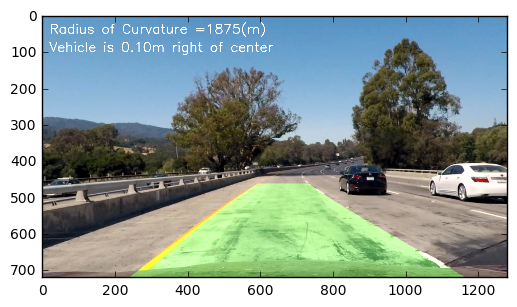

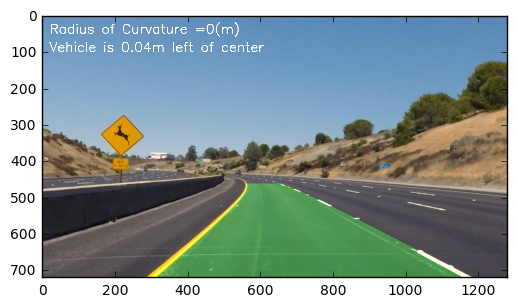

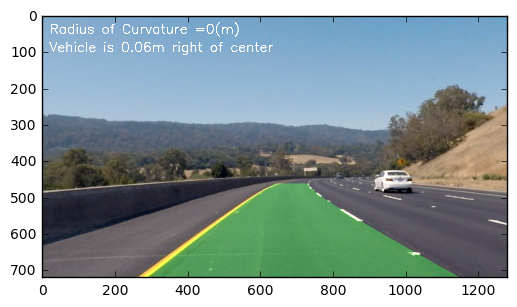

TypeError: 'NoneType' object is not subscriptable

In [10]:
img_path=os.getcwd()+'/test_images/'
for filename in glob.iglob(img_path+'test*.jpg'): 
    
#img=mpimg.imread(img_path+'test4.jpg')
    img=mpimg.imread(filename)
    left_line.__init__()
    right_line.__init__()
    ret=process_image(img, left_line, right_line, dbg=False)
    plt.imshow(ret)
    plt.show()

In [11]:
def image_pipeline(img):
    global left_line, right_line
    return process_image(img, left_line, right_line)
                  
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
video_output = 'project_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip_output = clip1.fl_image(image_pipeline) 
%time clip_output.write_videofile(video_output, audio=False)


[MoviePy] >>>> Building video project_result.mp4
[MoviePy] Writing video project_result.mp4


100%|█████████████████████████████████████▉| 1260/1261 [12:41<00:00,  1.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_result.mp4 

Wall time: 12min 45s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(clip_output))

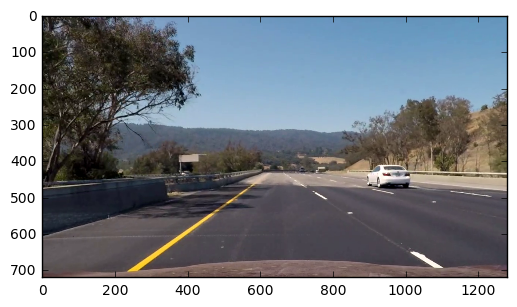

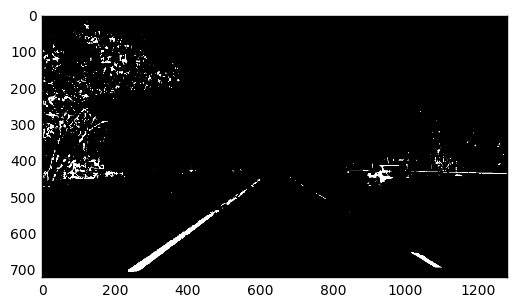

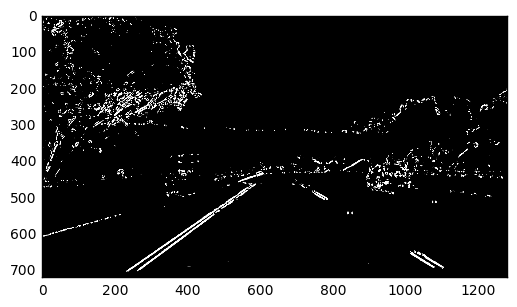

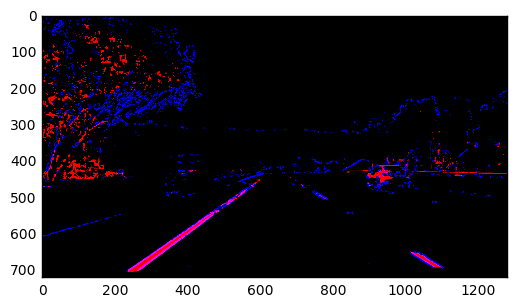

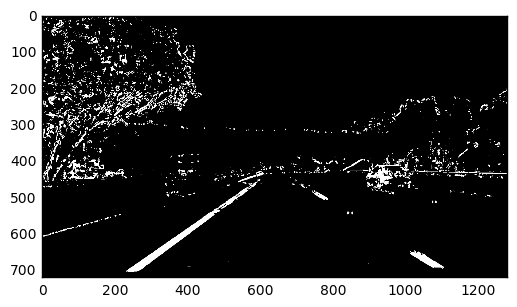

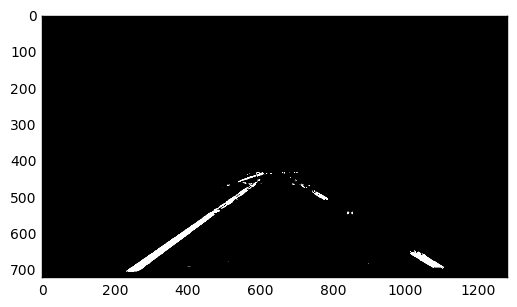

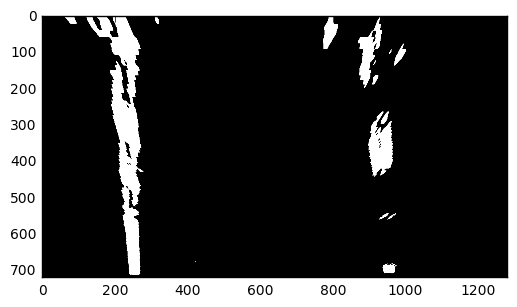

Line detected= True 864


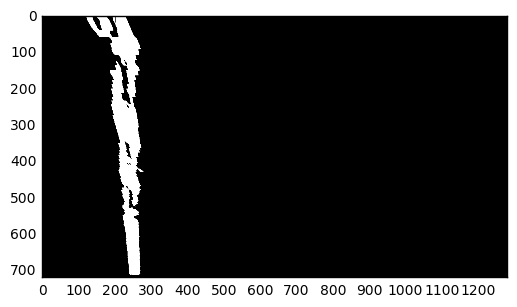

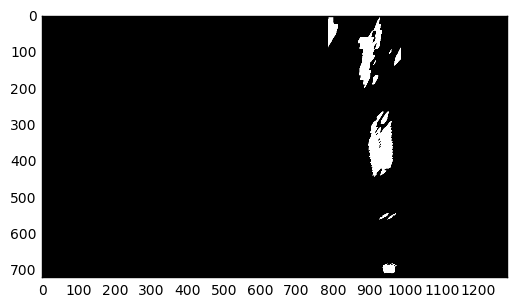

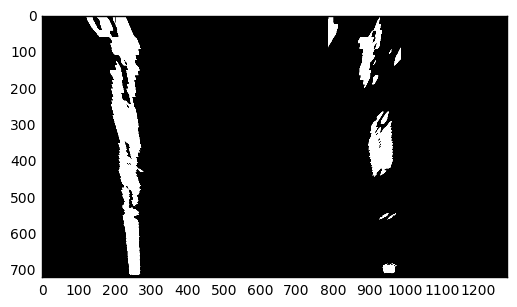

polynomial [ -1.19993827e-04   1.52623086e-01   1.98968004e+02]
base pos  246


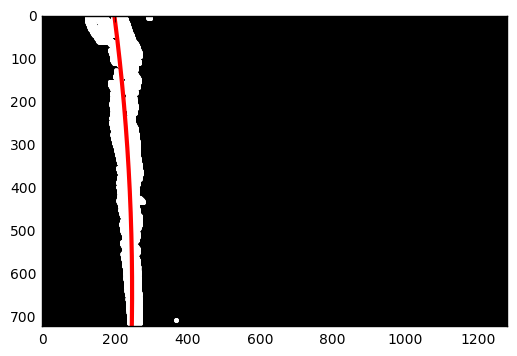

polynomial [ -2.63437663e-04   3.08435351e-01   8.56626162e+02]
base pos  942


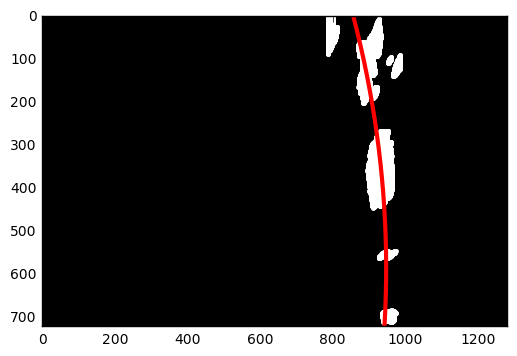

correlation coefficient [ 0.04707439]
lane_offset 0.2445402298850575 m
curverad left 10806.98172 right 2097.07415383


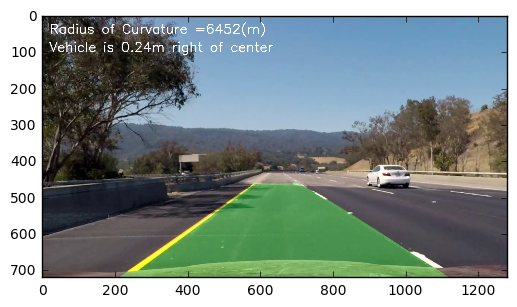

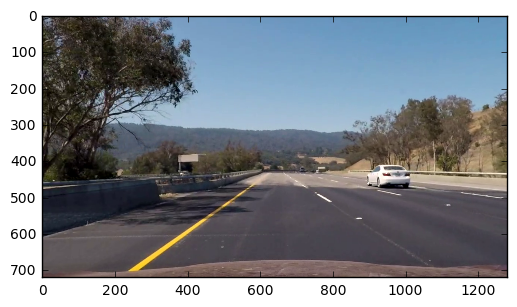

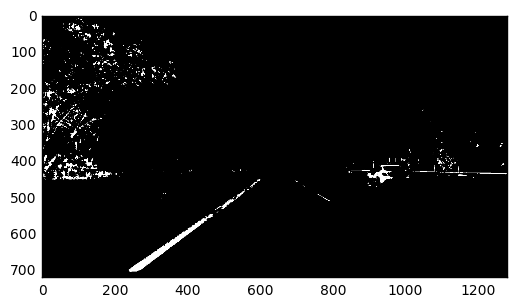

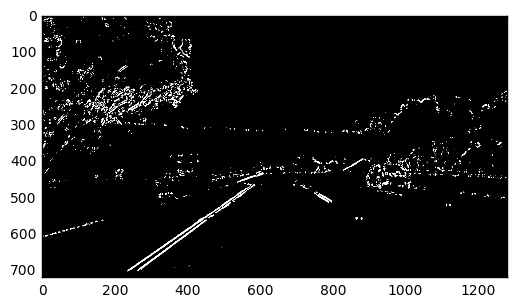

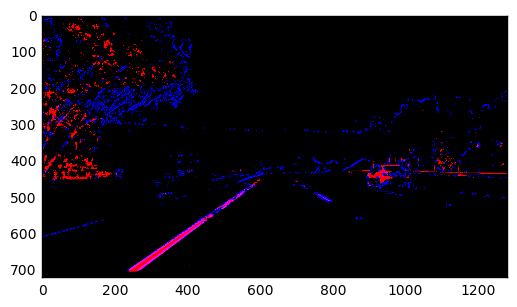

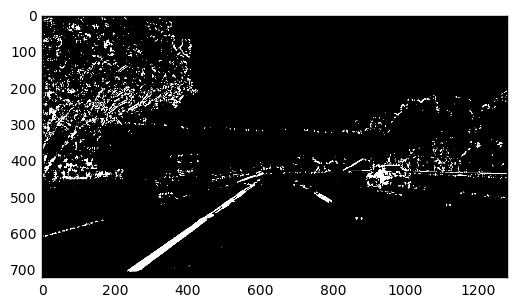

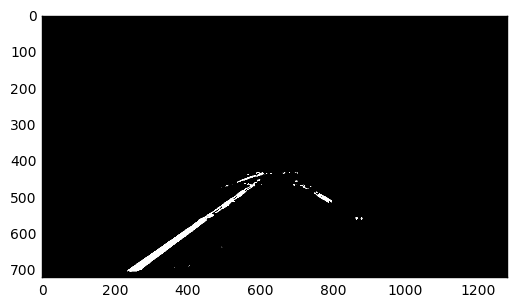

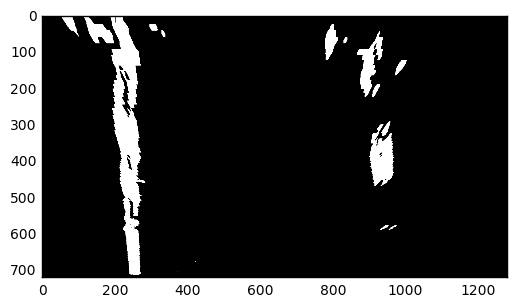

Line detected= True 942


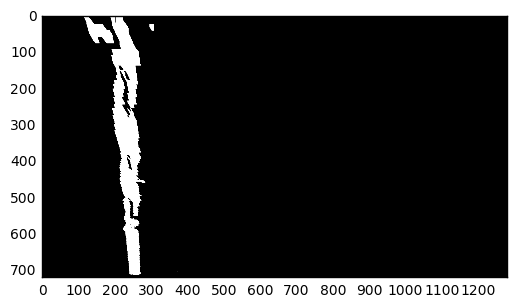

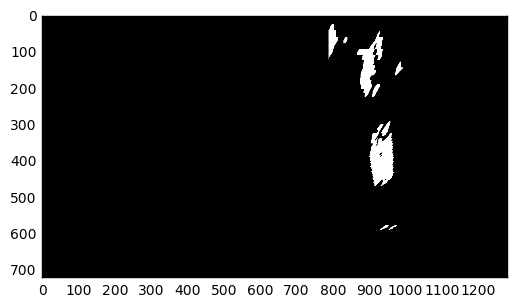

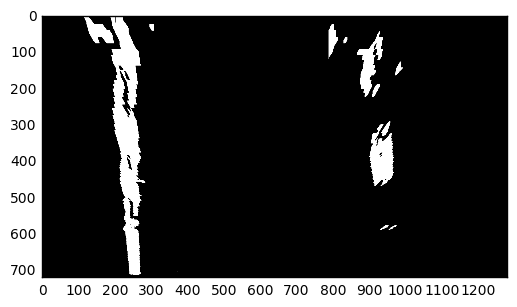

polynomial [ -1.59779780e-04   1.88426403e-01   1.92377582e+02]
base pos  245


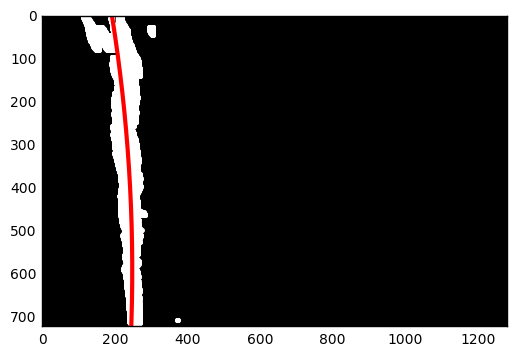

polynomial [ -7.01678923e-04   5.59405134e-01   8.25375917e+02]
base pos  864


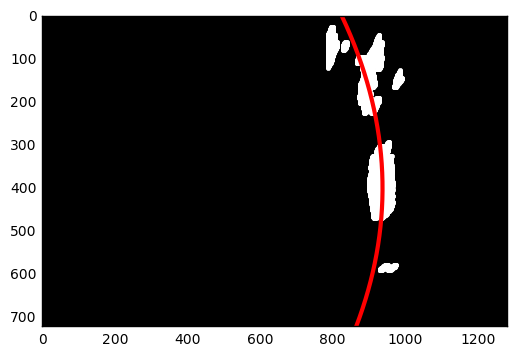

correlation coefficient [ 0.10540681]
lane_offset 0.5110662358642973 m
curverad left 10806.98172 right 2097.07415383


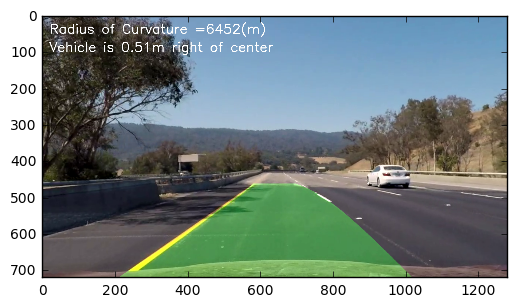

In [15]:
# For DEBUGGING
cap = cv2.VideoCapture("project_video.mp4") #video_name is the video being called
for fn in range(531,533):
    cap.set(1,fn); # Where frame_no is the frame you want
    ret, frame = cap.read() # Read the frame
    #cv2.imwrite('test.jpg',frame)
    frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    aug_frame=process_image(frame, left_line, right_line,dbg=True)
    
    aug_frame=cv2.cvtColor(aug_frame,cv2.COLOR_RGB2BGR)
    cv2.putText(aug_frame, "Frame "+str(fn), (400, 450),
           cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 2)    
    
    cv2.imshow('window_name', aug_frame) # show frame on window
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()

In [130]:
cv2.destroyAllWindows()